# fastai Tabular + Vision

In this kernel, we're going to see what it takes to combine both the Tabular and Image data from this competition into one `DataLoader`. While the resulting "`DataLoader`" may seem odd at first, I'll show you how it actually makes perfect sense.

First let's install grab the libraries we need:

In [1]:
!pip install fastai pydicom --quiet

In [2]:
from fastai.tabular.all import *
from fastai.vision.all import *
from fastai.medical.imaging import *

## The General Approach

Approaching this problem will be pretty straight forward. We're going to wrap a `TabDataLoader` and a `TfmdDL` (Or Vision `DataLoader`) together. To do this properly they need to share 3 functions:
  * `one_batch`
  * `shuffle_fn`
  * `show_batch`
  
Let's build our two `DataLoaders` real fast and then we'll explore why. We'll make it a very small subset for the sake of example:

In [3]:
path = Path("../input/siim-isic-melanoma-classification")

In [4]:
df = pd.read_csv(path/'train.csv')
test_df = pd.read_csv(path/'test.csv')

In [5]:
df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


I want to adjust the `image_name` to include either the `train` or `test` folder, this will help with inference:

In [6]:
df['image_name'] = 'train/' + df['image_name'].astype(str)
test_df['image_name'] = 'test/' + test_df['image_name'].astype(str)

## Tabular `DataLoader`

Let's build our `TabularDataLoader`. We'll want to define our `procs`, `cat` and `cont` names

In [7]:
cols = ['image_name', 'sex', 'age_approx',
       'anatom_site_general_challenge', 'diagnosis', 'benign_malignant',
       'target']
df = df[cols]
procs = [Categorify, FillMissing, Normalize]
cat_names  = ['sex', 'anatom_site_general_challenge']
cont_names = ['age_approx']
splitter = RandomSplitter(seed=42)
splits = splitter(range_of(df))
to = TabularPandas(df, procs, cat_names, cont_names,
                  y_names='target', y_block=CategoryBlock(),
                  splits=splits)

In [8]:
tab_dl = to.dataloaders(bs=8)

Next we'll move onto Vision

## Vision

Vision is a bit of a funky one. We're going to follow the `DataBlock` seen [here](https://www.kaggle.com/avirdee/fastai-dicom-starter) but we're going to adjust the splitter a bit to push everything to the `train`:

In [9]:
get_x = lambda x:path/f'{x[0]}.dcm'
get_y=ColReader('target')
batch_tfms = aug_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)
blocks = (ImageBlock(cls=PILDicom), CategoryBlock(vocab=[0,1]))
melanoma = DataBlock(blocks=blocks,
                   get_x=get_x,
                   splitter=splitter,
                   item_tfms=Resize(128),
                   get_y=ColReader('target'),
                   batch_tfms=batch_tfms)

In [10]:
vis_dl = melanoma.dataloaders(df, bs=8)

Now we grabbed `[0]` to get the `train` `DataLoader`:

In [11]:
type(vis_dl[0])

fastai.data.core.TfmdDL

# Combining the `DataLoaders`

Now for the part we all want and care about, how do we combine these two `DataLoaders`? We're going to build a "mock" `DataLoader` instead. It will have the same basic jobs as the regular `DataLoader`, but each time we call something for one, we will call it for both `DataLoaders`. We can do this as any time we iterate over the `DataLoader`, what we actually do is call `dl.one_batch` (during training, etc) so we just need to make those three functions I mentioned above. First, let's make our base.

What we want to do is override both `DataLoader`'s `shuffle_fn`, as what this function does is return a list of index's to grab. If the index's are the same, the data is the same, and that's all there is to it. In this particular case, we're going to be calling their `shuffle_fn`, etc multiple times, so we need to keep track of who actually is being called. We'll store this in a value called `count`. When it's 0, we'll grab some index's. When it's 1, we will return those index's (this is done at the beginning of each epoch to shuffle the `DataLoader`

## MixedDL

In [12]:
from fastai.data.load import _FakeLoader, _loaders

In [13]:
class MixedDL():
    def __init__(self, tab_dl:TabDataLoader, vis_dl:TfmdDL, device='cuda:0'):
        "Stores away `tab_dl` and `vis_dl`, and overrides `shuffle_fn`"
        self.device = device
        tab_dl.shuffle_fn = self.shuffle_fn
        vis_dl.shuffle_fn = self.shuffle_fn
        self.dls = [tab_dl, vis_dl]
        self.count = 0
        self.fake_l = _FakeLoader(self, False, 0, 0)
    
    def __len__(self): return len(self.dls[0])
        
    def shuffle_fn(self, idxs):
        "Generates a new `rng` based upon which `DataLoader` is called"
        if self.count == 0: # if we haven't generated an rng yet
            self.rng = self.dls[0].rng.sample(idxs, len(idxs))
            self.count += 1
            return self.rng
        else:
            self.count = 0
            return self.rng
        
    def to(self, device): self.device = device

And that's all there is to it. How do we check? Let's check the `DataLoader`'s index's

In [14]:
vis_dl[0].get_idxs()[:10]

[25035, 18672, 2592, 16973, 2633, 7691, 2422, 5892, 14756, 485]

In [15]:
tab_dl[0].get_idxs()[:10]

[1483, 5438, 11439, 21040, 13277, 2019, 12474, 5849, 2706, 10723]

Right now we see they are different

In [16]:
mixed_dl = MixedDL(tab_dl[0], vis_dl[0])

In [17]:
mixed_dl.dls[0].get_idxs()[:10]

[7138, 6720, 18562, 13867, 5789, 4165, 20106, 12874, 19476, 11881]

In [18]:
mixed_dl.dls[1].get_idxs()[:10]

[7138, 6720, 18562, 13867, 5789, 4165, 20106, 12874, 19476, 11881]

And now we can see our data is being shuffled the exact same way! Great! 

## One Batch

What more can we do?

We need to get our `one_batch` properly working, so let's focus on that. We'll make use of `fastcore`'s `patch` ability to save some room.

For our `grab_batch` function, we'll want to return 3 `xs` and one `y`:
  * Categorical
  * Continuous
  * Image
  
The first two are stored in the first two index's of the tabular batch, the final in the x of the vision batch. Let's write that:

But we have to do that in a few different ways. Specifically, this occurs in the `__iter__` function, and `one_batch` will grab the `first`. So let's build our `__iter__`:

In [19]:
@patch
def __iter__(dl:MixedDL):
    "Iterate over your `DataLoader`"
    z = zip(*[_loaders[i.fake_l.num_workers==0](i.fake_l) for i in dl.dls])
    for b in z:
        if dl.device is not None: 
            b = to_device(b, dl.device)
        batch = []
        batch.extend(dl.dls[0].after_batch(b[0])[:2])
        batch.append(dl.dls[1].after_batch(b[1][0]))
        try: # In case the data is unlabelled
            batch.append(b[1][1])
            yield tuple(batch)
        except:
            yield tuple(batch)

Now what did we do here? For us to iterate over everything nicely, we need to wrap it all in a `zip` (this is how the `__iter__` is on the original `DataLoader`. Then we want to return a set of `x` and `y`. 

But it's a little more than that. We need to run our `after_batch` transforms here, and before we do so, as we want those to be done on the GPU if possible, we need to (recursevly) convert all of our tensors to GPU via `to_device`. Finally we run the respective `after_batch` on each item needed. So now let's do `one_batch`:

In [20]:
@patch
def one_batch(x:MixedDL):
    "Grab a batch from the `DataLoader`"
    with x.fake_l.no_multiproc(): res = first(x)
    if hasattr(x, 'it'): delattr(x, 'it')
    return res

`one_batch` will need to call the first from the `DataLoader` (which is just `next(iter(dl))`), and if we are keeping track of an iterator, delete it. Finally returning our batch

And now let's see if it works:


In [21]:
batch = mixed_dl.one_batch()

Exception ignored in: <generator object MixedDL.__iter__ at 0x7f75b31d0cd0>
RuntimeError: generator ignored GeneratorExit


In [22]:
batch[0]

tensor([[1, 6, 1],
        [1, 2, 1],
        [1, 2, 1],
        [1, 5, 1],
        [2, 5, 1],
        [2, 1, 1],
        [2, 1, 1],
        [2, 2, 1]], device='cuda:0')

In [23]:
batch[1]

tensor([[ 1.1247],
        [ 0.0789],
        [-0.6182],
        [ 0.7761],
        [ 0.4275],
        [ 1.8218],
        [ 1.1247],
        [ 0.0789]], device='cuda:0')

In [24]:
batch[2]

TensorDicom([[[[0.4904, 0.4947, 0.5066,  ..., 0.5191, 0.5253, 0.5634],
          [0.4752, 0.4779, 0.4903,  ..., 0.5277, 0.5553, 0.5774],
          [0.4632, 0.4549, 0.4660,  ..., 0.5479, 0.5722, 0.5776],
          ...,
          [0.5507, 0.5424, 0.5516,  ..., 0.6885, 0.6768, 0.6781],
          [0.5476, 0.5397, 0.5462,  ..., 0.6766, 0.6608, 0.6686],
          [0.5370, 0.5286, 0.5338,  ..., 0.6942, 0.6862, 0.6880]],

         [[0.4350, 0.4348, 0.4349,  ..., 0.4125, 0.4107, 0.4287],
          [0.4280, 0.4309, 0.4308,  ..., 0.4139, 0.4235, 0.4361],
          [0.4273, 0.4236, 0.4269,  ..., 0.4315, 0.4355, 0.4384],
          ...,
          [0.4240, 0.4243, 0.4244,  ..., 0.4088, 0.4021, 0.3972],
          [0.4275, 0.4275, 0.4275,  ..., 0.4041, 0.4000, 0.3939],
          [0.4275, 0.4275, 0.4275,  ..., 0.4117, 0.4054, 0.4010]],

         [[0.6118, 0.6118, 0.6118,  ..., 0.6247, 0.6244, 0.6167],
          [0.6118, 0.6120, 0.6123,  ..., 0.6256, 0.6176, 0.6112],
          [0.6155, 0.6157, 0.6157,  .

In [25]:
batch[3]

TensorCategory([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

And now we see our batch returns what we want! What's left? Let's see if we can't merge our `show_batch`'s together:

## Show Batch

`show_batch` is probably the easiest out of all of them. We can try to improve it by say splitting up the batch and whatnot, or we can keep it easy and simple. Let's show a batch (which operates on the same batch in both) for both of our `DataLoaders`:

In [26]:
@patch
def show_batch(x:MixedDL):
    "Show a batch from multiple `DataLoaders`"
    for dl in x.dls:
        dl.show_batch()

Does it work? Let's see

,sex,anatom_site_general_challenge,age_approx_na,age_approx,target
0,female,upper extremity,False,65.0,0
1,female,lower extremity,False,50.0,0
2,female,lower extremity,False,40.0,0
3,female,torso,False,60.0,0
4,male,torso,False,55.0,0
5,male,head/neck,False,75.0,0
6,male,head/neck,False,65.0,0
7,male,lower extremity,False,50.0,0


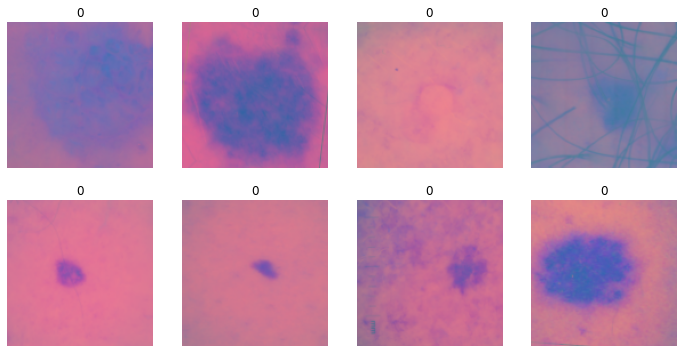

In [27]:
mixed_dl.show_batch()

It does! Right away! You now have all the bits needed to fully train your model. Have fun!

## Bonus: `test_dl`

Now how would we do inference? Let's look at first generating our `test_dl`. It's acutally very straightforward. For each of our interior `DataLoaders` (tab + image) we want to make their own `test_dl` that we pass to our `DataLoader`

Let's build one off of the `test_df`. We'll use the `test_dl` from both of the original `Tab` and `Image` `DataLoaders`:

In [28]:
im_test = vis_dl.test_dl(test_df)
tab_test = tab_dl.test_dl(test_df)

In [29]:
test_dl = MixedDL(tab_test, im_test)

And now for inference, (note this will not actually run, you need a model), we'll use my `fastinference` library, as regular `fastai` may not like our `DataLoaders`. First let's `pip` install it:

In [30]:
!pip install fastinference --quiet

And then import the inference module:

In [31]:
from fastinference.inference import *

Now to get your classes, all you need to do is run the commented out code below. `decoded_loss` will return your actual class values. To read more on `fastinference` see the documentation [here](muellerzr.github.io/fastinference):

The only thing we need to do is ensure we specify the number of inputs `learn.dls` is expecting:

In [32]:
#learn.dls.n_inp = 3

In [33]:
# preds = learn.get_preds(dl=test_dl, decoded_loss=True)